In [2]:
import nltk
import numpy as np
import pandas as pd

# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/sanbaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
df = pd.read_csv('../dataset/SPAM_MAILS_CSV.csv', encoding='ISO-8859-1')
df.sample(5)

,text,target
11862,FROM: DR. BEN KOKORI Compliments of the season...,1
1076,\n\nYou Can't Beat This Deal:\n\n\n\n200 Milli...,1
12235,"< html> <center> <p> <b> <font color = 3D "" re...",1
7726,"Nothing really, just making sure everybody's u...",0
6051,Bring home some Wendy =D,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15573 entries, 0 to 15572
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15573 non-null  object
 1   target  15573 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.5+ KB


In [7]:
# missing values
df.isnull().sum()

text      0
target    0
dtype: int64

## 1. Data Cleaning

In [8]:
# check for duplicate values
df.duplicated().sum()

0

In [9]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [10]:
df.duplicated().sum()

0

In [11]:
df.shape

(15573, 2)

## 2. EDA

In [12]:
df['target'].value_counts()

target
0    8398
1    7175
Name: count, dtype: int64

In [18]:
# type(df['target'].value_counts)

method

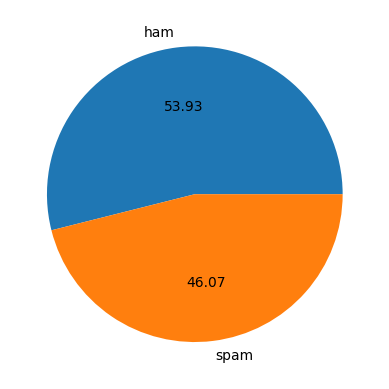

In [19]:
plt.pie(df['target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

## 3. Data Preprocessing
- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Stemming

In [21]:
import re
import nltk
import contractions
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Download the English stopwords if not already downloaded
nltk.download('stopwords')

# Set the English stopwords
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /home/sanbaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
def transform_text(text, max_repeating_chars=5):
    '''
    
    '''

    # Convert text to lowercase
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    
    # Remove HTML tags and content
    text = re.sub(r'<[^>]+>', ' ', text)

    # Remove numbers (including digits and numbers with commas or periods)
    text = re.sub(r'\d+[\d,\.]*', ' ', text)

    # Remove newline characters
    text = text.replace('\n', ' ')

    # Remove punctuations and unwanted characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    text = ' '.join(text.split())
    
    # Tokenize the text
    words = text.split()
        
    # Remove sequences of repeating characters
    words = [re.sub(r'(\w)\1{%d,}' % (max_repeating_chars - 1), r'\1', word) for word in words]

    # Remove single-character words and stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if len(word) > 2 and word not in stop_words]
    
    # Rejoin the words into a single string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [28]:
# Example usage:
input_text = "This is an example text with some irrelevant words like 'sanbaj', 'abcdefgh', 'x y z x y z x y z', 'sanbaj'."
cleaned_text = transform_text(input_text)
print(cleaned_text)


example text irrelevant words like sanbaj abcdefgh sanbaj


In [29]:

# Example usage:
input_text = "Your input text with HTML <b>tags</b>, punctuation, and stopwords.\nVisit http://example.com for more info."
cleaned_text = transform_text(input_text)
print(cleaned_text)


input text html tags punctuation stopwords visit info


In [30]:
df['text'][10]

'Dear Walmart shopper your purchase last month won a $1000 Walmart Gift Card, go to www.cCardSpot.com within 24 hours to claim.\n(NO2cancel)\n'

In [31]:
transform_text(df['text'][10])

'dear walmart shopper purchase last month walmart gift card within hours claim cancel'

In [32]:
df['transformed_text'] = df['text'].apply(transform_text)

In [33]:
def stem_email(email):
    stemmed_words = []
    for word in email.split(" "):
        stemmed_word = ps.stem(word)
        stemmed_words.append(stemmed_word)
    stemmed_email = " ".join(stemmed_words)
    
    return stemmed_email

df['stemmed_mail'] = df['transformed_text'].apply(stem_email)
df.head()

,text,target,transformed_text,stemmed_mail
0,National Security Department\nA vulnerability ...,0,national security department vulnerability ide...,nation secur depart vulner identifi appl facet...
1,U.S. Citizenship and Immigration Services\n\nC...,0,citizenship immigration services case number s...,citizenship immigr servic case number sfm pref...
2,Your PayPal account has been suspended due to ...,0,paypal account suspended due suspicious activi...,paypal account suspend due suspici activ pleas...
3,"You received 3 bitcoins ($14,242 USD) in your ...",0,received bitcoins usd account register accept ...,receiv bitcoin usd account regist accept transfer
4,"When elected, United Australia Party will ban ...",0,elected united australia party ban unsolicited...,elect unit australia parti ban unsolicit polit...


In [84]:
df.to_csv('../dataset/cleaned.csv', index=False)

In [34]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

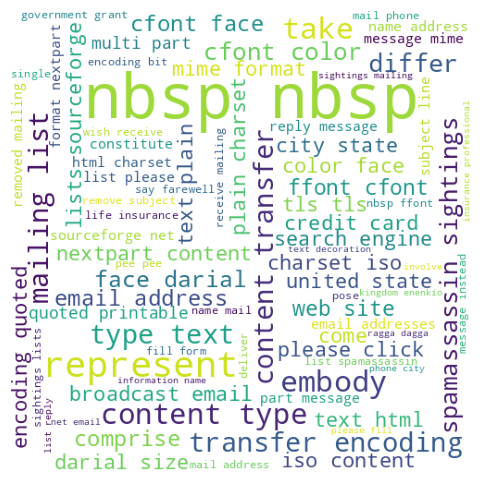

In [35]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)
plt.axis("off")
plt.show()

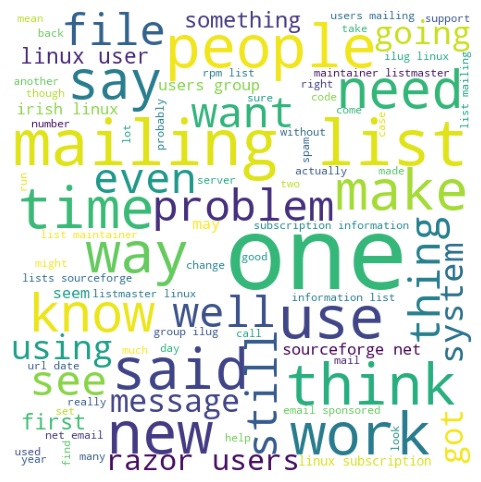

In [89]:
spam_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)
plt.axis("off")
plt.show()

In [90]:
from collections import Counter

def spam_words(df:pd.DataFrame)->list:
    spam_words = []
    for email in df[df['target']==1]['transformed_text'].tolist():
        for word in email.split():
            spam_words.append(word)

    words = Counter(spam_words).most_common(500)
    spam_words = [word[0] for word in words]

    return spam_words

In [91]:
spam_words(df)

['nbsp',
 'free',
 'email',
 'mail',
 'com',
 'please',
 'one',
 'money',
 'click',
 'get',
 'business',
 'represent',
 'list',
 'information',
 'take',
 'new',
 'content',
 'time',
 'address',
 'name',
 'differ',
 'people',
 'send',
 'order',
 'receive',
 'call',
 'make',
 'internet',
 'message',
 'report',
 'text',
 'home',
 'net',
 'size',
 'want',
 'may',
 'ffont',
 'cfont',
 'like',
 'would',
 'color',
 'use',
 'remove',
 'company',
 'type',
 'web',
 'embody',
 'mailing',
 'also',
 'site',
 'offer',
 'today',
 'nextpart',
 'million',
 'credit',
 'face',
 'day',
 'work',
 'life',
 'program',
 'removed',
 'best',
 'first',
 'service',
 'phone',
 'software',
 'government',
 'form',
 'marketing',
 'every',
 'state',
 'online',
 'reply',
 'transfer',
 'subject',
 'find',
 'need',
 'per',
 'help',
 'come',
 'year',
 'many',
 'price',
 'within',
 'cash',
 'even',
 'line',
 'quot',
 'special',
 'much',
 'available',
 'see',
 'grants',
 'number',
 'insurance',
 'product',
 'month',
 'searc

## 4. Model Building

In [50]:
X = df['stemmed_mail']
Y = df['target']

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=30000)
tfidf.fit_transform(X)

<15573x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 999770 stored elements in Compressed Sparse Row format>

In [52]:
X_tfidf_vectorized = tfidf.fit_transform(X).toarray()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_vectorized, Y, test_size=0.2, random_state=32)

print(X_train.shape)
print(X_test.shape)

(12458, 30000)
(3115, 30000)


In [114]:
def train_classifier(algorithm,X_train,y_train):
    model = algorithm.fit(X_train,y_train)
    return model

In [113]:
gnb = GaussianNB()
train_classifier(gnb, X_train, y_train, X_test, y_test)
confusion_matrix(y_test, y_pred)

{'accuracy_score': 0.9174959871589085, 'Precision_score': 0.9508448540706606}

In [115]:
gnb = GaussianNB()
gnb_model = train_classifier(gnb, X_train, y_train)
y_pred = gnb_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.9174959871589085
[[1620   64]
 [ 193 1238]]
0.9508448540706606
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      1684
           1       0.95      0.87      0.91      1431

    accuracy                           0.92      3115
   macro avg       0.92      0.91      0.92      3115
weighted avg       0.92      0.92      0.92      3115



In [117]:
mnb = MultinomialNB()
mnb_model = train_classifier(mnb, X_train, y_train)
y_pred = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9691813804173355
[[1614   70]
 [  26 1405]]
0.9525423728813559
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1684
           1       0.95      0.98      0.97      1431

    accuracy                           0.97      3115
   macro avg       0.97      0.97      0.97      3115
weighted avg       0.97      0.97      0.97      3115



In [118]:
bnb = BernoulliNB()
bnb_model = train_classifier(bnb, X_train, y_train)
y_pred = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.806099518459069
[[1650   34]
 [ 570  861]]
0.9620111731843576
              precision    recall  f1-score   support

           0       0.74      0.98      0.85      1684
           1       0.96      0.60      0.74      1431

    accuracy                           0.81      3115
   macro avg       0.85      0.79      0.79      3115
weighted avg       0.84      0.81      0.80      3115



In [121]:
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
etc.fit(X_train,y_train)
y_pred = etc.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_score(y_test,y_pred))    
# return accuracy,precision

0.9932584269662922
[[1674   10]
 [  11 1420]]
0.993006993006993


In [59]:
import pickle
pickle.dump(tfidf, open('../models/TfidfVectorizer.pkl','wb'))
pickle.dump(mnb, open('../models/mnb_model.pkl','wb'))